# MDA Final Project - Group33
本組的成員只有我一位，106061218李丞恩。

呼叫本次會使用到的package與SparkConf

In [1]:
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt

In [2]:
sc.stop()

In [3]:
conf = SparkConf().setMaster("local").setAppName("wordcount") # call sparkconf
conf = SparkConf().set("spark.default.parallelism", 4)
sc = SparkContext('local[8]', '', conf=conf) # call sparkcontext

## 一. 讀取dataset

CA-GrQc.txt的結構是兩個數字(vertex)間以tab隔開。我們將其讀取成RDD $G=[(i,j)]$，其中$i,j$為相連的兩個vertex。

In [4]:
def read_map(line):
    wordlist=line.split("\n")
    maplist=[]
    for item in wordlist:
        s = item.split("\t")
        if s[0] != s[1]: # 不讀入self edge
            maplist.append((int(s[0]), int(s[1]))) # add to map
            #maplist.append((int(s[1]), int(s[0]))) # add to map
    return maplist

In [5]:
G = sc.textFile("CA-GrQc.txt").flatMap(read_map) # read txt file

In [6]:
G.take(5)

[(3466, 937), (3466, 5233), (3466, 8579), (3466, 10310), (3466, 15931)]

## 二. 初始化Approximate PPR演算法所需的rdd

目標是把$G$變成$$G=\bigg[\big(u,([u連到的點],d_u,r_u,q_u,\frac{q_u}{d_u})\big)\bigg]$$
flatten2list會把巢狀結構展開為1維的list。length_reducer會將每個vertex的所有neighbor加到一個list中。

In [7]:
def flatten2list(object):
    gather = []
    for item in object:
        if isinstance(item, (list, tuple, set)):
            gather.extend(flatten2list(item))            
        else:
            gather.append(item)
    return gather

In [8]:
def length_reducer(x,y):
    return flatten2list((x,y))

而initilize_PPR則會初始化每個vertex的$d_u, r_u, q_u$以及$q_u/d_u$的值。

In [9]:
def initilize_PPR(x):
    if x[0] == 9572: # seed node
        qu = 1 # residual PPR of a vertex
    else:
        qu = 0
    if isinstance(x[1], int):
        du = 1 # degree of a vertex
    else:
        du = len(x[1]) 
    ru = 0 # PPR score of a vertex
    return (x[0], (x[1], du, ru, qu, qu/du))

原本$G$的結構是剛讀入的dataset $[(i,j)]$，其中$i,j$為相連的兩個vertex。經過length_reducer以及initilize_PPR後，就能成功地將$G$變為$$G=\bigg[\big(u,([u連到的點],d_u,r_u,q_u,\frac{q_u}{d_u})\big)\bigg]$$的形式了。

In [10]:
G = G.reduceByKey(length_reducer)

In [11]:
G = G.map(initilize_PPR)

而因為執行了一次reduce，照理來說此時$G$的元素個數即為這個dataset所含的vertex數，但因為有一個vertex只有一條self edge，因此會被排除掉。

In [12]:
G.count()

5241

## 三. Approximate PPR演算法實作

### 1. 選擇適當起點
Choose any vertex $u$ such that $$\max_{u\in V}\frac{q_u}{d_u}\geq\epsilon$$故要先找出具有該最大值的頂點。記得此時的
$$G=\bigg[\big(u,([u連到的點],d_u,r_u,q_u,\frac{q_u}{d_u})\big)\bigg]$$
因此find_max()函數中需先經過一次map，使$q_u/d_u$成為value，才能使用RDD的max()方法尋找出具有最大值的頂點。完成後，將其map回$G$原本的形式後回傳。

In [13]:
beta = 0.8

In [14]:
def find_max():
    max_vertex = G.map(lambda x: ((x[0],x[1][0],x[1][1],x[1][2],x[1][3]),x[1][4])) \
                  .max(key = lambda x:x[1]) # fincd max(qu/du)
    max_vertex = (max_vertex[0][0],(max_vertex[0][1],max_vertex[0][2],max_vertex[0][3], \
                                    max_vertex[0][4],max_vertex[1]))  
    return max_vertex

### 2. Push

現在的$G$是$$\bigg[\big(u,([u連到的點],d_u,r_u,q_u,\frac{q_u}{d_u})\big)\bigg]$$
在Push的第一階段，先用Push_map1()讓它變成$$\bigg[\big(u,([u連到的點],d_u,r_u+(1-\beta)q_u,0.5\beta q_u,\frac{q_u}{d_u})\big)\bigg]$$

In [15]:
def Push_map1(x):
    if x[0] == max_vertex[0]:
        return (x[0], (x[1][0],x[1][1],x[1][2]+(1-beta)*x[1][3],0.5*beta*x[1][3],x[1][4]))
    else:
        return x

迴圈因為timeout的因素只能執行四次，詳情請見報告。迴圈內的code的解釋如下：
1. 首先先找出使得$$\frac{q_u}{d_u}=\max_{u\in V}\frac{q_u}{d_u}\geq\epsilon$$的頂點$u$，因此使用find_max()執行。

2. 對所有$u$的neighbor$v$，要以$$q_v+\frac{1}{2}\beta\frac{q_u}{d_u}\to q_v$$更新$q_v$的值。因此使用G.filter()，將$G$中所有元素，其編號位在$u$的neighbor list(也就是$[u連到的點]$)中的點存到另一個rdd $V$裡面，接著對$V$利用一次map完成此更新。

3. 由於所有neighbor的$q$值已經更新，要將它們放回$G$裡的話，需要先刪除$G$中原本相同的頂點，再利用G.union(V)的方法將$G$與$V$併在一起

In [16]:
for i in range(1,5): # under construction!
    max_vertex = find_max()
    G = G.map(Push_map1) # 更新ru與qu
    
    #找出具有最大max_val之vertex所連到的邊
    V = G.filter(lambda x: x[0] in max_vertex[1][0] if not isinstance(max_vertex[1][0], int) else x[0] == max_vertex[1][0])
    V = V.map(lambda x: (x[0], (x[1][0],x[1][1],x[1][2], \
                            x[1][3]+0.5*beta*max_vertex[1][3]/max_vertex[1][1], \
                            x[1][4]))) # qv<-qv+0.5*beta*qu/du
    # 濾掉已經在V中的邊
    G = G.filter(lambda x: x[0] not in max_vertex[1][0] if not isinstance(max_vertex[1][0], int) else x[0] != max_vertex[1][0])
    G = G.union(V) #更新所有邊的參數
    print("第%d次迭代已完成" %i, end='\r')

取每個vertex的編號以及$r_u$值，將結果存到文字檔中，只是pyspark會分割所有輸出檔並放在一個資料夾(Final_project_output)中，要手動在其中的part-00000~part-00003加上.txt才能讀取。

In [17]:
output = G.map(lambda x: (x[0], x[1][2]))
output.saveAsTextFile("Final_project_output")

以下的code是在報告中提及，逐行運行的code，雖然與用迴圈寫會出一樣的問題，不過可藉由觀察其輸出驗證演算法的正確性。

In [18]:
#max_vertex = find_max()

In [19]:
#max_vertex

In [20]:
#G = G.map(Push_map1) # 更新ru與qu

In [21]:
#V = G.filter(lambda x: x[0] in max_vertex[1][0] if not isinstance(max_vertex[1][0], int) else x[0] == max_vertex[1][0])
#V = V.map(lambda x: (x[0], (x[1][0],x[1][1],x[1][2], \
#                            x[1][3]+0.5*beta*max_vertex[1][3]/max_vertex[1][1], \
#                            x[1][4]))) # qv<-qv+0.5*beta*qu/du

In [22]:
#G = G.filter(lambda x: x[0] not in max_vertex[1][0] if not isinstance(max_vertex[1][0], int) else x[0] != max_vertex[1][0])

In [23]:
#G.count()

In [24]:
#G = G.union(V)

In [25]:
#G.count()

## 四. 資料分析

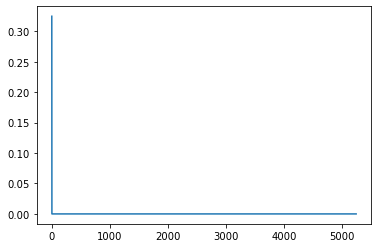

In [26]:
output_list = output.collect()
data={}
for i in output_list:
    data[i[0]] = i[1]
    
plt.plot(sorted(data.values())[::-1])
plt.savefig("PPR.png", dpi=500)
plt.show()